In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')
sys.path.append('..')

# Maths
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, ConnectionPatch
from matplotlib.patches import Rectangle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, BoundaryNorm, DivergingNorm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.colors import to_rgba

# ML
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.svm import SVC
from sklearn.neighbors import KernelDensity
from sklearn.datasets import make_classification


# Atoms
from ase.io import read
from soap import extract_species_pair_groups

# Utilities
import h5py
from tools import load_json, save_json
from tqdm.notebook import tqdm
import project_utils as utils

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle

# Analysis setup

In [4]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [5]:
# Load train and test indices
deem_train_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_train.idxs', dtype=int)
deem_test_idxs = np.loadtxt('../../Processed_Data/DEEM_330k/svm_test.idxs', dtype=int)

iza_train_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_train.idxs', dtype=int)
iza_test_idxs = np.loadtxt('../../Processed_Data/IZA_230/svm_test.idxs', dtype=int)

In [6]:
# Load indices of DEEM 10k set in 330k
idxs_deem_10k = np.loadtxt('../../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [7]:
# Load cantons for IZA and Deem
iza_cantons = np.loadtxt('../../Raw_Data/IZA_230/cantons_compositions.dat', usecols=1, dtype=int)
deem_cantons_2 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_2-class.dat', dtype=int)
deem_cantons_4 = np.loadtxt('../../Processed_Data/DEEM_330k/Data/cantons_4-class.dat', dtype=int)
n_deem = len(deem_cantons_2)

In [8]:
# Build set of "master" canton labels for the train set
train_cantons = {}

train_cantons[4] = np.concatenate((
    iza_cantons[iza_train_idxs], 
    deem_cantons_4[deem_train_idxs]
))

train_cantons[2] = np.concatenate((
    np.ones(len(iza_train_idxs), dtype=int),
    deem_cantons_2[deem_train_idxs]
))

train_class_weights = {
    n_cantons: utils.balanced_class_weights(train_cantons[n_cantons]) for n_cantons in (2, 4)
}

# Build set of "master" canton labels for the test set
test_cantons = {}

test_cantons[4] = np.concatenate((
    iza_cantons[iza_test_idxs], 
    deem_cantons_4[deem_test_idxs]
))

test_cantons[2] = np.concatenate((
    np.ones(len(iza_test_idxs), dtype=int),
    deem_cantons_2[deem_test_idxs]
))

test_class_weights = {
    n_cantons: utils.balanced_class_weights(test_cantons[n_cantons]) for n_cantons in (2, 4)
}

In [9]:
# Load dummy Deem cantons to test the "null" case
dummy_cantons = {}
dummy_cantons[2] = np.loadtxt('../../Processed_Data/DEEM_330k/Data/dummy_cantons_2-class.dat', dtype=int)
dummy_cantons[4] = np.loadtxt('../../Processed_Data/DEEM_330k/Data/dummy_cantons_4-class.dat', dtype=int)

In [10]:
# Master set of dummy labels for the train set
dummy_train_cantons = {}
dummy_train_cantons[2] = dummy_cantons[2][deem_train_idxs]
dummy_train_cantons[4] = dummy_cantons[4][deem_train_idxs]

dummy_train_class_weights = {
    n_cantons: utils.balanced_class_weights(dummy_train_cantons[n_cantons]) for n_cantons in (2, 4)
}

# Master set of dummy labels for the test set
dummy_test_cantons = {}
dummy_test_cantons[2] = dummy_cantons[2][deem_test_idxs]
dummy_test_cantons[4] = dummy_cantons[4][deem_test_idxs]

dummy_test_class_weights = {
    n_cantons: utils.balanced_class_weights(dummy_test_cantons[n_cantons]) for n_cantons in (2, 4)
}

In [11]:
class_names = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']

}

ticklabels = {
    2: ['IZA', 'DEEM'],
    4: ['IZA1', 'IZA2', 'IZA3', 'DEEM']
}

dummy_ticklabels = {
    2: ['DEEM1', 'DEEM2'],
    4: ['DEEM1', 'DEEM2', 'DEEM3', 'DEEM4']
}

In [12]:
# Linear model setup
n_species = 2
group_names = {
    'power': ['OO', 'OSi', 'SiSi', 'OO+OSi', 'OO+SiSi', 'OSi+SiSi', 'OO+OSi+SiSi'], 
    'radial': ['O', 'Si', 'O+Si']
}
df_types = ['OvR', 'OvO']
df_type = 'OvR'

In [13]:
deem_name = 'DEEM_330k'
iza_name = 'IZA_230'
deem_dir = f'../../Processed_Data/{deem_name}/Data'
iza_dir = f'../../Processed_Data/{iza_name}/Data'

# LR check

# Classification statistics

In [14]:
accuracies = {}
balanced_accuracies = {}
for cutoff in cutoffs:
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        
        for species_pairing in group_names[spectrum_type]:

            for n_cantons in (2, 4):
                
                # Prepare outputs
                data_dir = f'LSVC/{df_type}/{n_cantons}-Class/{spectrum_name}/{species_pairing}'
            
                print(f'===== {cutoff} | {n_cantons}-Class | {spectrum_name} | {species_pairing} =====')

                predicted_cantons_iza = np.loadtxt(
                    f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )
                predicted_cantons_deem = np.loadtxt(
                    f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )

                predicted_train_cantons = np.concatenate((
                    predicted_cantons_iza[iza_train_idxs],
                    predicted_cantons_deem[deem_train_idxs]
                ))
                predicted_test_cantons = np.concatenate((
                    predicted_cantons_iza[iza_test_idxs],
                    predicted_cantons_deem[deem_test_idxs]
                ))

                matrix_train = confusion_matrix(
                    train_cantons[n_cantons], predicted_train_cantons
                )
                matrix_test = confusion_matrix(
                    test_cantons[n_cantons], predicted_test_cantons
                )

                print('----- Train -----')
                print(
                    classification_report(
                        train_cantons[n_cantons], predicted_train_cantons, zero_division=0
                    )
                )
                print('Train accuracy:', balanced_accuracy_score(
                    train_cantons[n_cantons], predicted_train_cantons
                ))
                print()
                print(matrix_train)
                print()

                print('----- Test -----')
                print(
                    classification_report(
                        test_cantons[n_cantons], predicted_test_cantons, zero_division=0
                    )
                )
                print('Test accuracy:', balanced_accuracy_score(
                    test_cantons[n_cantons], predicted_test_cantons
                ))
                print()
                print(matrix_test)
                print()
                
                # Save model accuracies so we can find the best
                accuracies[f'{cutoff}_{n_cantons}-Class_{spectrum_name}_{species_pairing}'] = \
                    accuracy_score(test_cantons[n_cantons], predicted_test_cantons)
                balanced_accuracies[f'{cutoff}_{n_cantons}-Class_{spectrum_name}_{species_pairing}'] = \
                    balanced_accuracy_score(test_cantons[n_cantons], predicted_test_cantons)

===== 3.5 | 2-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.11      0.99      0.19       114
           2       1.00      0.91      0.95      9999

    accuracy                           0.91     10113
   macro avg       0.55      0.95      0.57     10113
weighted avg       0.99      0.91      0.94     10113

Train accuracy: 0.9487093446186724

[[ 113    1]
 [ 938 9061]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.88      0.01       115
           2       1.00      0.91      0.95    321082

    accuracy                           0.91    321197
   macro avg       0.50      0.89      0.48    321197
weighted avg       1.00      0.91      0.95    321197

Test accuracy: 0.8920412176978765

[[   101     14]
 [ 30239 290843]]

===== 3.5 | 4-Class | Power | OO =====
----- Train -----
              precision    recall  f1-score   support

           1       0.02  

===== 3.5 | 2-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.12      0.99      0.21       114
           2       1.00      0.92      0.96      9999

    accuracy                           0.92     10113
   macro avg       0.56      0.95      0.58     10113
weighted avg       0.99      0.92      0.95     10113

Train accuracy: 0.9540098746716776

[[ 113    1]
 [ 832 9167]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.93      0.01       115
           2       1.00      0.91      0.96    321082

    accuracy                           0.91    321197
   macro avg       0.50      0.92      0.48    321197
weighted avg       1.00      0.91      0.95    321197

Test accuracy: 0.9223358221101856

[[   107      8]
 [ 27537 293545]]

===== 3.5 | 4-Class | Power | OO+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1   

===== 3.5 | 2-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.05      0.89      0.09       114
           2       1.00      0.81      0.89      9999

    accuracy                           0.81     10113
   macro avg       0.52      0.85      0.49     10113
weighted avg       0.99      0.81      0.88     10113

Train accuracy: 0.8467728351782546

[[ 101   13]
 [1924 8075]]

----- Test -----
              precision    recall  f1-score   support

           1       0.00      0.83      0.00       115
           2       1.00      0.81      0.89    321082

    accuracy                           0.81    321197
   macro avg       0.50      0.82      0.45    321197
weighted avg       1.00      0.81      0.89    321197

Test accuracy: 0.8174401744319411

[[    95     20]
 [ 61393 259689]]

===== 3.5 | 4-Class | Radial | Si =====
----- Train -----
              precision    recall  f1-score   support

           1       0.02

===== 6.0 | 2-Class | Power | SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.20      0.98      0.34       114
           2       1.00      0.96      0.98      9999

    accuracy                           0.96     10113
   macro avg       0.60      0.97      0.66     10113
weighted avg       0.99      0.96      0.97     10113

Train accuracy: 0.9694258899574167

[[ 112    2]
 [ 436 9563]]

----- Test -----
              precision    recall  f1-score   support

           1       0.01      0.90      0.01       115
           2       1.00      0.95      0.97    321082

    accuracy                           0.95    321197
   macro avg       0.50      0.92      0.49    321197
weighted avg       1.00      0.95      0.97    321197

Test accuracy: 0.9215835694687772

[[   103     12]
 [ 16852 304230]]

===== 6.0 | 4-Class | Power | SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.

===== 6.0 | 2-Class | Power | OO+OSi+SiSi =====
----- Train -----
              precision    recall  f1-score   support

           1       0.21      0.98      0.35       114
           2       1.00      0.96      0.98      9999

    accuracy                           0.96     10113
   macro avg       0.61      0.97      0.67     10113
weighted avg       0.99      0.96      0.97     10113

Train accuracy: 0.9707760249709181

[[ 112    2]
 [ 409 9590]]

----- Test -----
              precision    recall  f1-score   support

           1       0.01      0.89      0.01       115
           2       1.00      0.95      0.98    321082

    accuracy                           0.95    321197
   macro avg       0.50      0.92      0.49    321197
weighted avg       1.00      0.95      0.97    321197

Test accuracy: 0.9193473535001082

[[   102     13]
 [ 15496 305586]]

===== 6.0 | 4-Class | Power | OO+OSi+SiSi =====
----- Train -----
              precision    recall  f1-score   support

       

In [15]:
save_json(accuracies, '../../Processed_Data/Models/svc_accuracy.json')
save_json(balanced_accuracies, '../../Processed_Data/Models/svc_balanced_accuracy.json')

In [16]:
print('----- Accuracy Rank -----')
for i in utils.rank_models(accuracies):
    print(i)
    
print()

print('----- Balanced Accuracy Rank -----')
for i in utils.rank_models(balanced_accuracies):
    print(i)

----- Accuracy Rank -----
('6.0_4-Class_Power_OO+SiSi', 0.9776025305342204)
('6.0_2-Class_Power_OO+SiSi', 0.9744922897785471)
('6.0_4-Class_Power_OO', 0.9724187959414315)
('6.0_2-Class_Power_OO', 0.9688290986528517)
('6.0_2-Class_Power_OSi+SiSi', 0.95263343057376)
('6.0_2-Class_Power_OO+OSi+SiSi', 0.951714991111374)
('6.0_4-Class_Power_OSi+SiSi', 0.9515344165730066)
('6.0_4-Class_Power_OO+OSi+SiSi', 0.9503855889064966)
('6.0_2-Class_Power_OSi', 0.9496414972742585)
('6.0_2-Class_Power_OO+OSi', 0.9491869475742302)
('6.0_4-Class_Power_OSi', 0.9487977783105073)
('6.0_4-Class_Power_OO+OSi', 0.9481564273638919)
('6.0_2-Class_Power_SiSi', 0.947496396292618)
('6.0_2-Class_Radial_O+Si', 0.9467803248473678)
('3.5_4-Class_Power_OO+OSi+SiSi', 0.9419639660395334)
('6.0_4-Class_Power_SiSi', 0.9414658293819681)
('3.5_2-Class_Power_OO+OSi+SiSi', 0.9409458992456343)
('3.5_4-Class_Power_OSi+SiSi', 0.9401862408428472)
('3.5_4-Class_Power_OO+SiSi', 0.9379477392379132)
('3.5_4-Class_Power_OSi', 0.931945192

# Confusion matrices

## IZA + Deem

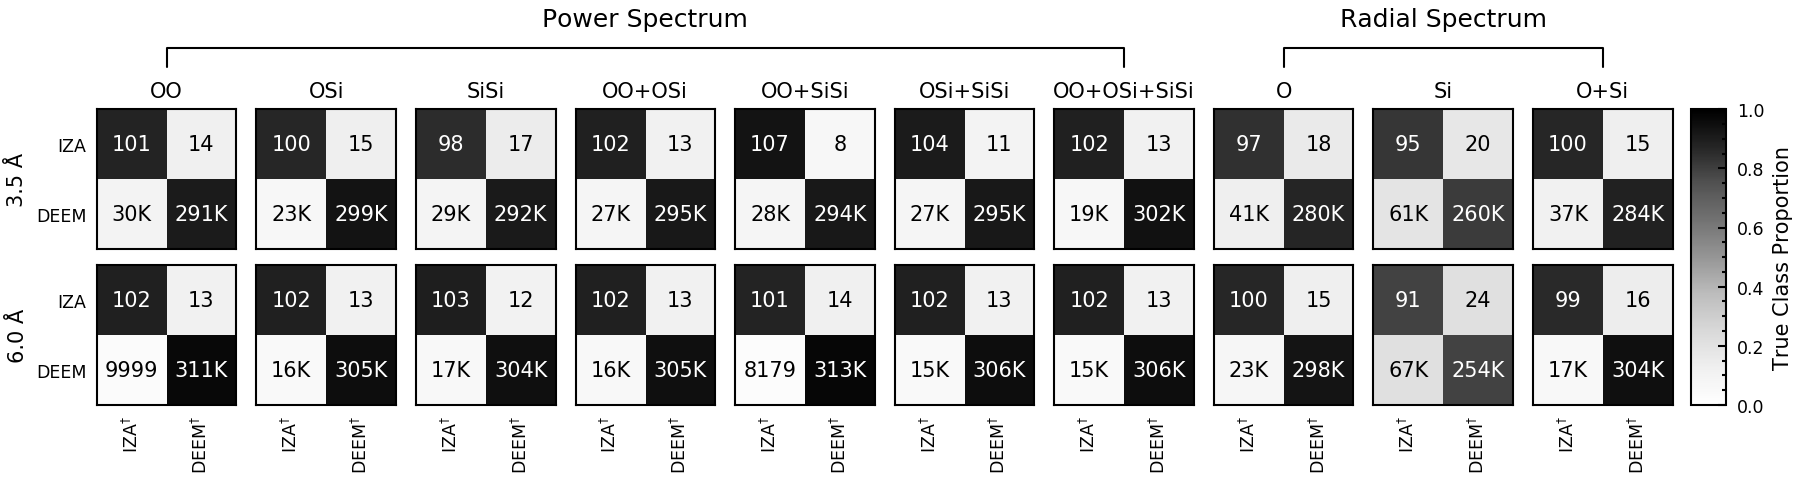

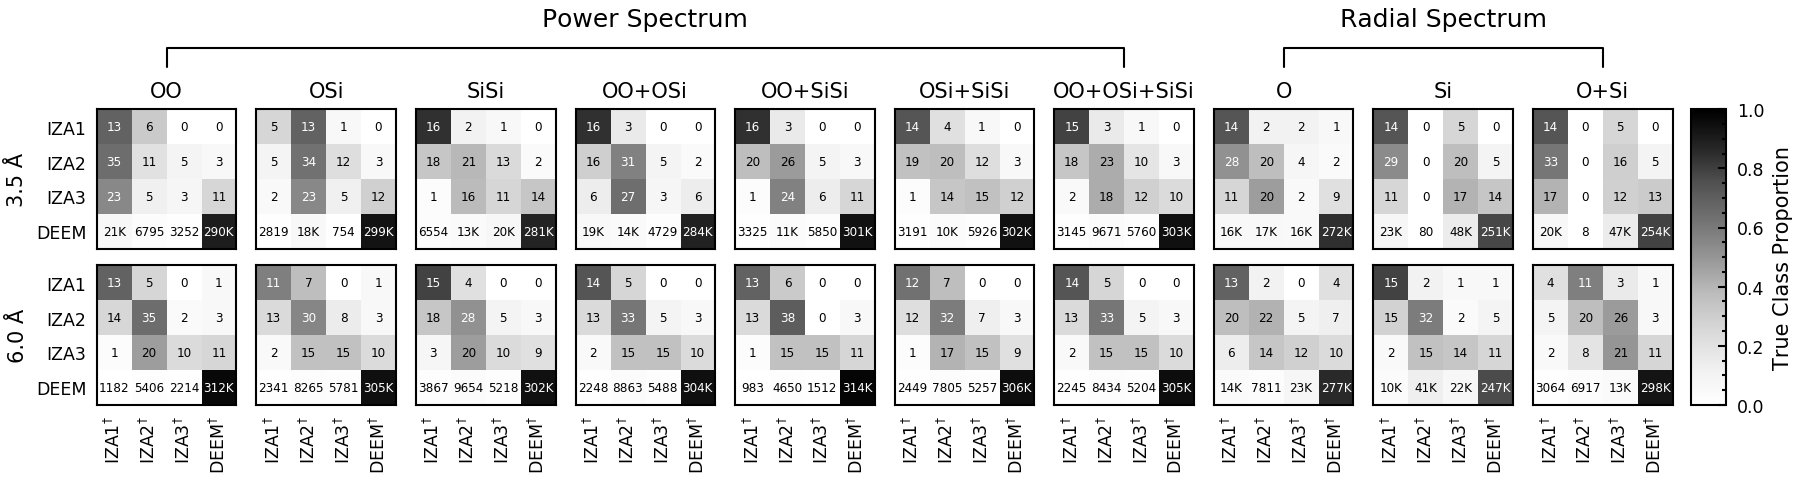

In [17]:
fig_2class = plt.figure(figsize=(12, 2.7), constrained_layout=True)
fig_4class = plt.figure(figsize=(12, 2.7), constrained_layout=True)

n_rows = 2
n_cols = 10

vmin = 0.0
vmax = 1.0

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(
        nrows=n_rows, ncols=n_cols+1, 
        width_ratios=width_ratios,
        hspace=0.05, wspace=0.05
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for spectrum_type in ('power', 'radial'):
            spectrum_name = spectrum_type.capitalize()

            for species_pairing in group_names[spectrum_type]:

                # Prepare outputs
                data_dir = f'LSVC/{df_type}/{n_cantons}-Class/{spectrum_name}/{species_pairing}'

                predicted_cantons_iza = np.loadtxt(
                    f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )
                predicted_cantons_deem = np.loadtxt(
                    f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
                )

                predicted_train_cantons = np.concatenate((
                    predicted_cantons_iza[iza_train_idxs],
                    predicted_cantons_deem[deem_train_idxs]
                ))
                predicted_test_cantons = np.concatenate((
                    predicted_cantons_iza[iza_test_idxs],
                    predicted_cantons_deem[deem_test_idxs]
                ))

                matrix_train = confusion_matrix(train_cantons[n_cantons], predicted_train_cantons)
                matrix_test = confusion_matrix(test_cantons[n_cantons], predicted_test_cantons)

                matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)
                
                for i in range(0, n_cantons):
                    matrix_ref[i, i] = np.count_nonzero(test_cantons[n_cantons] == (i + 1))
                    
                matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]
                
                ax = axes[row_idx, col_idx]
                ax.imshow(matrix_norm, cmap='Greys', vmin=vmin, vmax=vmax)
                
                if n_cantons == 2:
                    text_size = 'medium'
                else:
                    text_size = 'xx-small'
                
                for i in range(0, n_cantons):
                    for j in range(0, n_cantons):
                        if matrix_norm[i, j] > (0.5 * vmax):
                            text_color = 'w'
                        else:
                            text_color = 'k'
                            
                        if len(str(matrix_test[i, j])) > 4:
                            
                            # This isn't a very 'robust' way of doing this,
                            # but since we only go up to 6 digits, this should work
                            # (we do this shortening only if the number has 6 digits)
                            box_number_str = str(round(matrix_test[i, j], -3))
                            box_number_str = box_number_str[0:-3] + 'K'
                        else:
                            box_number_str = f'{matrix_test[i, j]:d}'
                        
                        ax.text(
                            j, i, box_number_str,
                            horizontalalignment='center', verticalalignment='center',
                            color=text_color, fontsize=text_size
                        )
                
                ax.set_xticks(np.arange(0, n_cantons))
                ax.set_yticks(np.arange(0, n_cantons))
                
                ax.tick_params(
                    axis='both', which='both', 
                    left=False, bottom=False, right=False, top=False,
                    labelleft=False, labelbottom=False, labelright=False, labeltop=False
                )
                
                if col_idx == 0:
                    ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                    ax.set_yticklabels(ticklabels[n_cantons])
                    ax.tick_params(axis='y', which='both', labelleft=True)
                    
                if row_idx == 0:
#                     ax.set_title(f'{species_pairing}', fontsize='small')
                    ax.set_title(species_pairing, fontsize='medium')
                elif row_idx == (n_rows - 1):
                    ax.set_xticklabels(
                        [tick + r'$^{\dag}$' for tick in ticklabels[n_cantons]], rotation=90
                    )
                    ax.tick_params(axis='x', which='both', labelbottom=True)

                col_idx += 1
        
        row_idx += 1        
    
    cp_xy = (0.5, 1.3)
    cp_power_bar_frac = -0.02
    cp_radial_bar_frac = cp_power_bar_frac * 3
    cp_power = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 0].transAxes,
        xyB=cp_xy, coordsB=axes[0, 6].transAxes,
        connectionstyle=f'bar,fraction={cp_power_bar_frac}'
    )
    cp_radial = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 7].transAxes,
        xyB=cp_xy, coordsB=axes[0, 9].transAxes,
        connectionstyle=f'bar,fraction={cp_radial_bar_frac}'
    )
    
    n_power = len(group_names['power'])
    n_radial = len(group_names['radial'])
    
    power_label_ax = axes[0, n_power // 2]
    if n_power % 2 == 0:
        power_shift = 0.5
    else:
        power_shift = 0.0
        
    radial_label_ax = axes[0, n_radial // 2 + n_power]
    if n_radial % 2 == 0:
        radial_shift = 0.5
    else:
        radial_shift = 0.0
    
    fig.text(
        0.5 - power_shift, 1.65, 'Power Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=power_label_ax.transAxes, fontsize='large'
    )
    
    fig.text(
        0.5 - radial_shift, 1.65, 'Radial Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=radial_label_ax.transAxes, fontsize='large'
    )
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(
        ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Greys'), cax=cax
    )
    cb.set_label('True Class Proportion')
    
    fig.add_artist(cp_power)
    fig.add_artist(cp_radial)
    
    fig.savefig(f'../../Results/svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    
plt.show()

## Dummy prediction

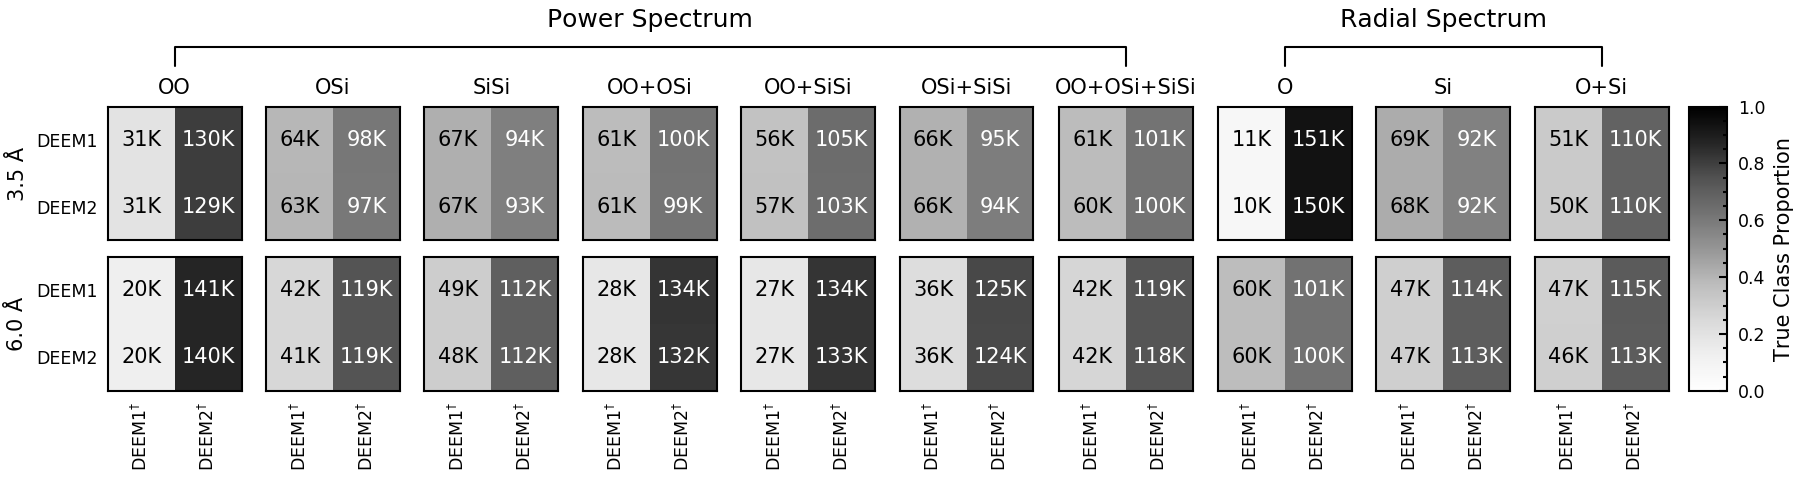

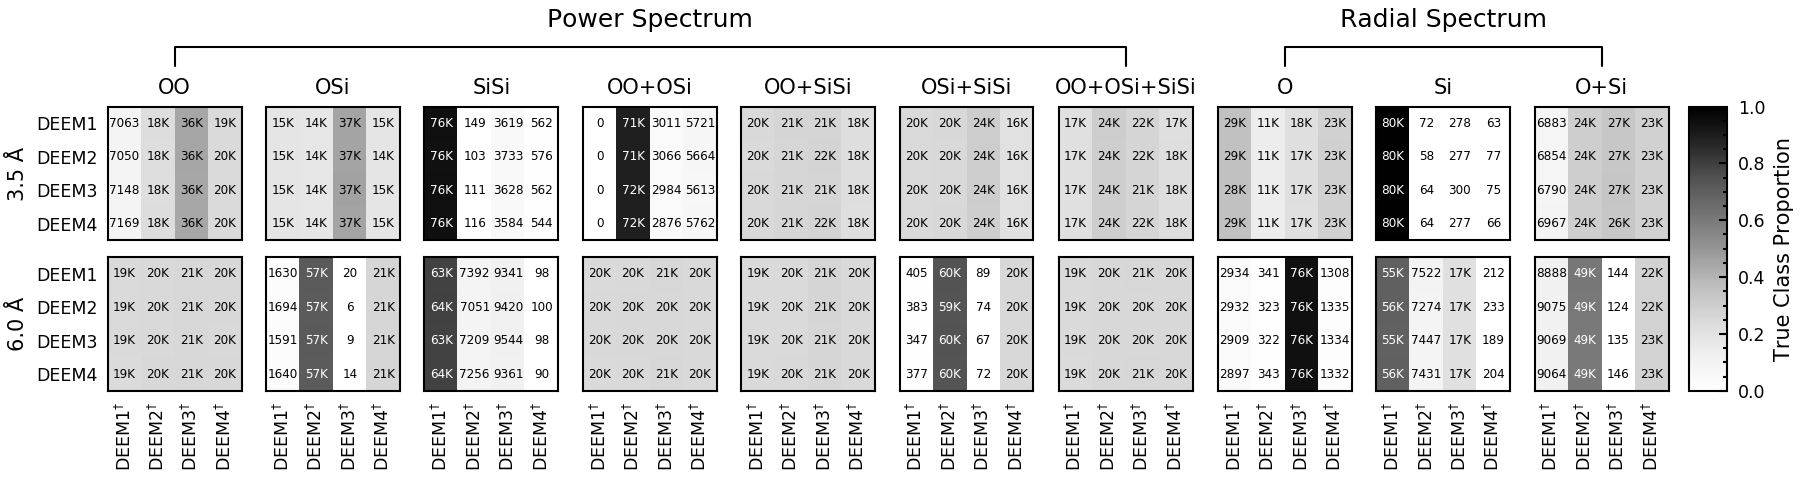

In [18]:
fig_2class = plt.figure(figsize=(12, 2.7), constrained_layout=True)
fig_4class = plt.figure(figsize=(12, 2.7), constrained_layout=True)

n_rows = 2
n_cols = 10

vmin = 0.0
vmax = 1.0

width_ratios = np.ones(n_cols + 1)
width_ratios[-1] = 0.25

for fig, n_cantons in zip((fig_2class, fig_4class), (2, 4)):
    gs = fig.add_gridspec(
        nrows=n_rows, ncols=n_cols+1, 
        width_ratios=width_ratios,
        hspace=0.05, wspace=0.05
    )
    axes = np.array([[fig.add_subplot(gs[i, j]) for j in range(0, n_cols)] for i in range(0, n_rows)])
    row_idx = 0
    for cutoff in cutoffs:
        col_idx = 0
        for spectrum_type in ('power', 'radial'):
            spectrum_name = spectrum_type.capitalize()

            for species_pairing in group_names[spectrum_type]:

                # Prepare outputs
                data_dir = f'LSVC/{df_type}/{n_cantons}-Class/{spectrum_name}/{species_pairing}'

                predicted_dummy_cantons = np.loadtxt(
                    f'{deem_dir}/{cutoff}/{data_dir}/dummy_svc_structure_cantons.dat', dtype=int
                )
                predicted_dummy_train_cantons = predicted_dummy_cantons[deem_train_idxs]
                predicted_dummy_test_cantons = predicted_dummy_cantons[deem_test_idxs]

                matrix_train = confusion_matrix(
                    dummy_train_cantons[n_cantons], predicted_dummy_train_cantons
                )
                matrix_test = confusion_matrix(
                    dummy_test_cantons[n_cantons], predicted_dummy_test_cantons
                )

                matrix_ref = np.zeros((n_cantons, n_cantons), dtype=int)
                
                for i in range(0, n_cantons):
                    matrix_ref[i, i] = np.count_nonzero(dummy_test_cantons[n_cantons] == (i + 1))
                    
                matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]
                
                ax = axes[row_idx, col_idx]
                ax.imshow(matrix_norm, cmap='Greys', vmin=vmin, vmax=vmax)
                
                if n_cantons == 2:
                    text_size = 'medium'
                else:
                    text_size = 'xx-small'
                
                for i in range(0, n_cantons):
                    for j in range(0, n_cantons):
                        if matrix_norm[i, j] > (0.5 * vmax):
                            text_color = 'w'
                        else:
                            text_color = 'k'
                            
                        if len(str(matrix_test[i, j])) > 4:
                            
                            # This isn't a very 'robust' way of doing this,
                            # but since we only go up to 6 digits, this should work
                            # (we do this shortening only if the number has 6 digits)
                            box_number_str = str(round(matrix_test[i, j], -3))
                            box_number_str = box_number_str[0:-3] + 'K'
                        else:
                            box_number_str = f'{matrix_test[i, j]:d}'
                        
                        ax.text(
                            j, i, box_number_str,
                            horizontalalignment='center', verticalalignment='center',
                            color=text_color, fontsize=text_size
                        )
                
                ax.set_xticks(np.arange(0, n_cantons))
                ax.set_yticks(np.arange(0, n_cantons))
                
                ax.tick_params(
                    axis='both', which='both', 
                    left=False, bottom=False, right=False, top=False,
                    labelleft=False, labelbottom=False, labelright=False, labeltop=False
                )
                
                if col_idx == 0:
                    ax.set_ylabel(f'{cutoff} ' + u'\u00c5')
                    ax.set_yticklabels(dummy_ticklabels[n_cantons])
                    ax.tick_params(axis='y', which='both', labelleft=True)
                    
                if row_idx == 0:
#                     ax.set_title(f'{species_pairing}', fontsize='small')
                    ax.set_title(species_pairing, fontsize='medium')
                elif row_idx == (n_rows - 1):
                    ax.set_xticklabels(
                        [tick + r'$^{\dag}$' for tick in dummy_ticklabels[n_cantons]], rotation=90
                    )
                    ax.tick_params(axis='x', which='both', labelbottom=True)

                col_idx += 1
        
        row_idx += 1        
    
    cp_xy = (0.5, 1.3)
    cp_power_bar_frac = -0.02
    cp_radial_bar_frac = cp_power_bar_frac * 3
    cp_power = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 0].transAxes,
        xyB=cp_xy, coordsB=axes[0, 6].transAxes,
        connectionstyle=f'bar,fraction={cp_power_bar_frac}'
    )
    cp_radial = ConnectionPatch(
        xyA=cp_xy, coordsA=axes[0, 7].transAxes,
        xyB=cp_xy, coordsB=axes[0, 9].transAxes,
        connectionstyle=f'bar,fraction={cp_radial_bar_frac}'
    )
    
    n_power = len(group_names['power'])
    n_radial = len(group_names['radial'])
    
    power_label_ax = axes[0, n_power // 2]
    if n_power % 2 == 0:
        power_shift = 0.5
    else:
        power_shift = 0.0
        
    radial_label_ax = axes[0, n_radial // 2 + n_power]
    if n_radial % 2 == 0:
        radial_shift = 0.5
    else:
        radial_shift = 0.0
    
    fig.text(
        0.5 - power_shift, 1.65, 'Power Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=power_label_ax.transAxes, fontsize='large'
    )
    
    fig.text(
        0.5 - radial_shift, 1.65, 'Radial Spectrum',
        horizontalalignment='center', verticalalignment='center',
        transform=radial_label_ax.transAxes, fontsize='large'
    )
    
    cax = fig.add_subplot(gs[:, -1])
    cb = fig.colorbar(
        ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), cmap='Greys'), cax=cax
    )
    cb.set_label('True Class Proportion')
    
    fig.add_artist(cp_power)
    fig.add_artist(cp_radial)
    
    fig.savefig(f'../../Results/dummy_svc_confusion_matrices_{n_cantons}-class.pdf', bbox_inches='tight')
    
plt.show()

# ROC curves

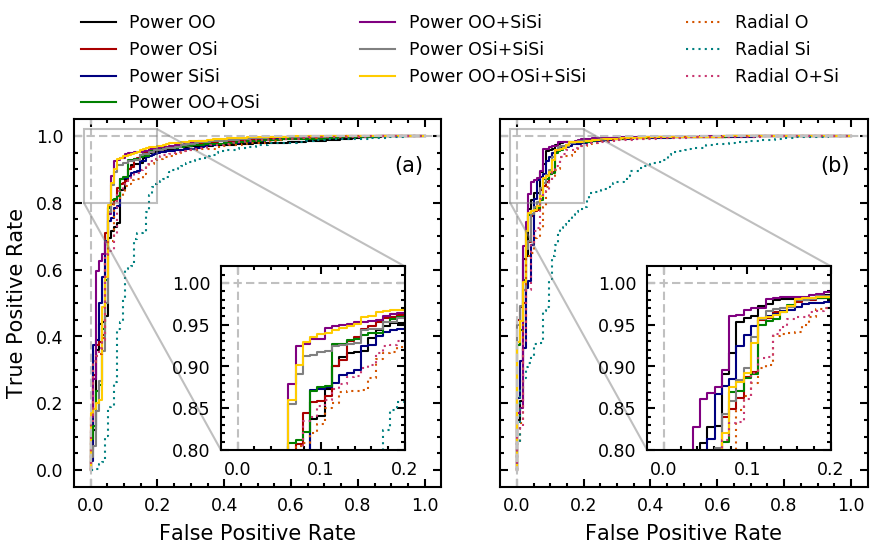

In [19]:
# ROC curves
aucs = {}
fig = plt.figure(figsize=(7.0, 7.0))
axs = {}
axs[3.5] = fig.add_subplot(2, 2, 1)
axs[6.0] = fig.add_subplot(2, 2, 2)
legend_lines = {cutoff: [] for cutoff in cutoffs}

plot_parameters = dict(power={'linestyle': '-'}, radial={'linestyle': ':'})

for cutoff, subfigure_label in zip(cutoffs, ['(a)', '(b)']):
    model_dir = f'../../Processed_Data/Models/{cutoff}'
    axs[cutoff].set_aspect('equal')
    axs_inset = axs[cutoff].inset_axes([0.40, 0.10, 0.50, 0.50])
    roc_line_pairs = []
    max_auc = 0.0
    max_auc_idx = 0
    plot_idx = 0
    for spectrum_type in ('power', 'radial'):
        spectrum_name = spectrum_type.capitalize()
        plot_parameters['linestyle'] = ''
        for species_pairing in group_names[spectrum_type]:
            data_dir = f'LSVC/{df_type}/2-Class/{spectrum_name}/{species_pairing}'
            
            dfs_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            dfs_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
            
            test_dfs = np.concatenate((dfs_iza[iza_test_idxs], dfs_deem[deem_test_idxs]))
            
            fpr, tpr, thresholds = roc_curve(
                test_cantons[2], 
                test_dfs,
                pos_label=2
            )
            auc = roc_auc_score(
                test_cantons[2],
                test_dfs,
                average='macro'
            )
            
            aucs[f'{cutoff}_2-Class_{spectrum_name}_{species_pairing}'] = auc
            
            if auc > max_auc:
                max_auc = auc
                max_auc_idx = plot_idx
                
            plot_idx += 1
            
            line_pair = []
            for ax in (axs[cutoff], axs_inset):
                line = ax.plot(
                    fpr, tpr, **plot_parameters[spectrum_type], 
                    label=f'{spectrum_name} {species_pairing}')
                line_pair.extend(line)
            roc_line_pairs.append(line_pair)
    
    for ldx, line_pair in enumerate(roc_line_pairs):
        legend_lines[cutoff].append(Line2D(
            [0], [0], 
            label=line_pair[0].get_label(), 
            color=line_pair[0].get_color(),
            linestyle=line_pair[0].get_linestyle(),
            alpha=1.0
        ))

        if ldx == max_auc_idx:
            color_transparency = ''
#             line_scale = 2
            line_scale = 1
        else:
            color_transparency = '' # Hex for alpha = 0.25
#             color_transparency = '40' # Hex for alpha = 0.25
            line_scale = 1
            
        for line in line_pair:
            line.set_color(line.get_color() + color_transparency)
            line.set_linewidth(line.get_linewidth() * line_scale)
                            
    zoom_x = ([-0.02, 0.20])
    zoom_y = ([0.80, 1.02])
    axs_inset.set_xlim(zoom_x)
    axs_inset.set_ylim(zoom_y)    
                
    for ax in (axs[cutoff], axs_inset):        
        ax.axvline(0.0, color=color_list[11], linestyle='--')
        ax.axhline(1.0, color=color_list[11], linestyle='--')
        
    axs[cutoff].indicate_inset_zoom(axs_inset, label=None)

#     axs[cutoff].set_xlim([-0.01, 0.2])
    axs[cutoff].set_xlabel('False Positive Rate')
    
    axs[cutoff].text(
#         0.95, 0.90, f'{subfigure_label} {cutoff} ' + u'\u00c5',
        0.95, 0.90, f'{subfigure_label}',
        horizontalalignment='right', verticalalignment='top',
        transform=axs[cutoff].transAxes
    )

wspace=0.1
axs[3.5].set_ylabel('True Positive Rate')

axs[3.5].legend(
    handles=legend_lines[3.5], bbox_to_anchor=(0.0, 1.0, 2.0+wspace, 0.5), 
    loc='lower left', bbox_transform=axs[3.5].transAxes,
    ncol=3, mode='expand', borderaxespad=0.0
)

axs[6.0].tick_params(axis='y', which='both', labelleft=False)

fig.subplots_adjust(wspace=wspace)

fig.savefig('../../Results/roc_svc.pdf', bbox_inches='tight')

plt.show()

In [20]:
save_json(aucs, '../../Processed_Data/Models/svc_auc.json')

In [21]:
# Unsorted; easier to put in a table
for k, v in aucs.items():
    print(k, v)

3.5_2-Class_Power_OO 0.9306859171556608
3.5_2-Class_Power_OSi 0.9433501613972104
3.5_2-Class_Power_SiSi 0.939764540711935
3.5_2-Class_Power_OO+OSi 0.9369071370905387
3.5_2-Class_Power_OO+SiSi 0.9578260246671376
3.5_2-Class_Power_OSi+SiSi 0.9407721121219746
3.5_2-Class_Power_OO+OSi+SiSi 0.9493972418802403
3.5_2-Class_Radial_O 0.9298707657775624
3.5_2-Class_Radial_Si 0.8615486278325759
3.5_2-Class_Radial_O+Si 0.9320351322958811
6.0_2-Class_Power_OO 0.9660856240705679
6.0_2-Class_Power_OSi 0.9636912472311693
6.0_2-Class_Power_SiSi 0.9586615961302585
6.0_2-Class_Power_OO+OSi 0.9642481414066513
6.0_2-Class_Power_OO+SiSi 0.9703191626790176
6.0_2-Class_Power_OSi+SiSi 0.965547145886883
6.0_2-Class_Power_OO+OSi+SiSi 0.9656403903865274
6.0_2-Class_Radial_O 0.9479960828102153
6.0_2-Class_Radial_Si 0.8656958279383052
6.0_2-Class_Radial_O+Si 0.9481459294022955


In [22]:
print('----- AUC Rank -----')
for i in utils.rank_models(aucs):
    print(i)

----- AUC Rank -----
('6.0_2-Class_Power_OO+SiSi', 0.9703191626790176)
('6.0_2-Class_Power_OO', 0.9660856240705679)
('6.0_2-Class_Power_OO+OSi+SiSi', 0.9656403903865274)
('6.0_2-Class_Power_OSi+SiSi', 0.965547145886883)
('6.0_2-Class_Power_OO+OSi', 0.9642481414066513)
('6.0_2-Class_Power_OSi', 0.9636912472311693)
('6.0_2-Class_Power_SiSi', 0.9586615961302585)
('3.5_2-Class_Power_OO+SiSi', 0.9578260246671376)
('3.5_2-Class_Power_OO+OSi+SiSi', 0.9493972418802403)
('6.0_2-Class_Radial_O+Si', 0.9481459294022955)
('6.0_2-Class_Radial_O', 0.9479960828102153)
('3.5_2-Class_Power_OSi', 0.9433501613972104)
('3.5_2-Class_Power_OSi+SiSi', 0.9407721121219746)
('3.5_2-Class_Power_SiSi', 0.939764540711935)
('3.5_2-Class_Power_OO+OSi', 0.9369071370905387)
('3.5_2-Class_Radial_O+Si', 0.9320351322958811)
('3.5_2-Class_Power_OO', 0.9306859171556608)
('3.5_2-Class_Radial_O', 0.9298707657775624)
('6.0_2-Class_Radial_Si', 0.8656958279383052)
('3.5_2-Class_Radial_Si', 0.8615486278325759)


In [23]:
best_2class_cutoff = float(utils.rank_models(balanced_accuracies, keys=['2-Class'])[0][0].split('_')[0])
print(best_2class_cutoff)

6.0


In [24]:
best_2class_model = {}
for cutoff in cutoffs:
    best_2class_model[cutoff] = {}
    (
        _, _, 
        best_2class_model[cutoff]['best_spectrum'], 
        best_2class_model[cutoff]['best_species']
    ) = utils.rank_models(balanced_accuracies, keys=[str(cutoff), '2-Class'])[0][0].split('_')
    
print(best_2class_model)

{3.5: {'best_spectrum': 'Power', 'best_species': 'OO+SiSi'}, 6.0: {'best_spectrum': 'Power', 'best_species': 'OO'}}


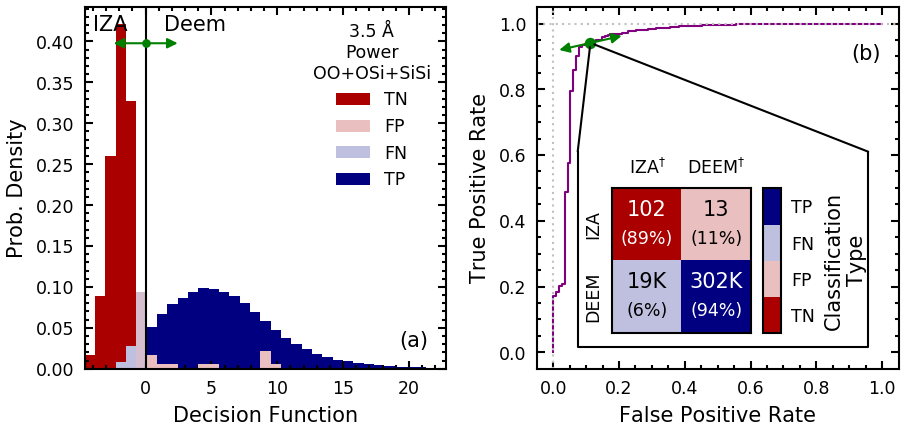

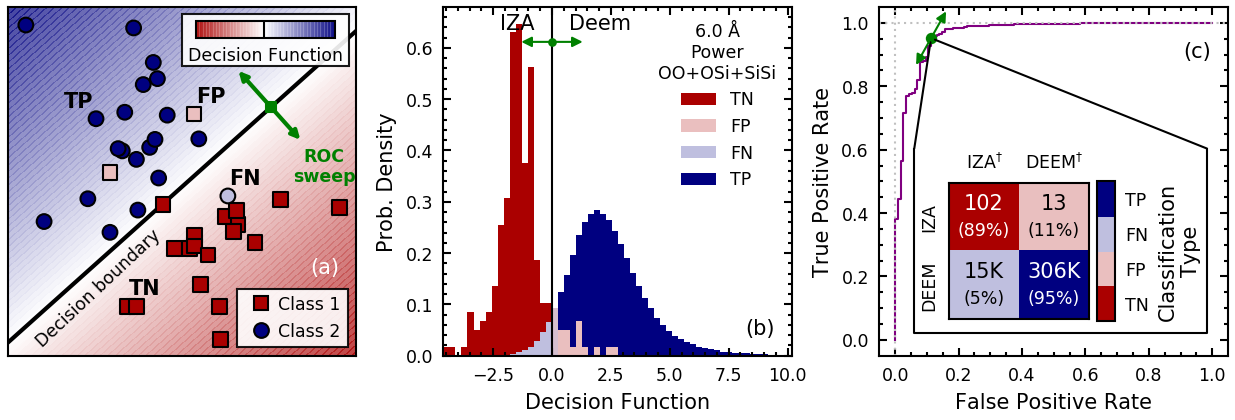

In [25]:
# Custom colors for classes
matrix_colors = [
    np.array(to_rgba(c, alpha=1.0)) for c in [color_list[1], color_list[1], color_list[2], color_list[2]]
]
white_mix = 0.75
for i in range(1, 3):
    matrix_colors[i] = white_mix * np.ones(4) + (1.0 - white_mix) * matrix_colors[i]

cmap = ListedColormap(matrix_colors)
cmap_norm = BoundaryNorm(np.arange(0, cmap.N + 1), cmap.N)

# "Best" ROC curve with confusion matrix inset
for cutoff in cutoffs: 
    
    # Automatic model selection
#     best_spectrum = best_2class_model[cutoff]['best_spectrum']
#     best_species = best_2class_model[cutoff]['best_species']
    
    # Manual model selection
    best_2class_cutoff = 6.0
    best_spectrum = 'Power'
    best_species = 'OO+OSi+SiSi'
    if cutoff == best_2class_cutoff:
        subfigure_labels = ['(a)', '(b)', '(c)']
        fig = plt.figure(figsize=(10.5, 3.5))
        n_plots = 3
        toy_axs = fig.add_subplot(1, n_plots, 1)
        X, y = make_classification(
            n_samples=40,
            n_features=2,
            n_informative=2,
            n_redundant=0,
            n_repeated=0,
            n_classes=2,
            n_clusters_per_class=1,
            class_sep=0.50,
            random_state=100
        )
        svc = SVC(kernel='linear', class_weight='balanced')
        svc.fit(X, y)
        
        yp = svc.predict(X)
        y_colors = np.zeros(len(y), dtype=int)
        y_colors[(yp == 0) & (y == 0)] = 0 # TN
        y_colors[(yp == 1) & (y == 0)] = 1 # FP
        y_colors[(yp == 0) & (y == 1)] = 2 # FN
        y_colors[(yp == 1) & (y == 1)] = 3 # TP
        for cls, marker in zip((0, 1), ('s', 'o')):
            toy_axs.scatter(
                X[y == cls, 0], X[y == cls, 1],
                marker=marker, c=y_colors[y == cls], s=50,
                cmap=cmap, norm=cmap_norm, edgecolor='k', 
                zorder=2
            )
            
        toy_xlim = toy_axs.get_xlim()
        toy_ylim = toy_axs.get_ylim()
        toy_axs.set_aspect((toy_xlim[1] - toy_xlim[0]) / (toy_ylim[1] - toy_ylim[0]), anchor='C')
        
        n_grid = 50
        xx, yy = np.meshgrid(
            np.linspace(toy_xlim[0], toy_xlim[1], n_grid),
            np.linspace(toy_ylim[0], toy_ylim[1], n_grid)
        )
        df_toy = np.reshape(
            svc.decision_function(np.column_stack((xx.flatten(), yy.flatten()))),
            (n_grid, n_grid)
        )
        df_cmap = LinearSegmentedColormap.from_list('CustomRdBu', [color_list[1], '#FFFFFF', color_list[2]])
        df_cmap_norm = DivergingNorm(0.0)
        df_contour = toy_axs.contourf(
            xx, yy, df_toy, 
            levels=100, 
            cmap=df_cmap, norm=df_cmap_norm, 
            alpha=0.75, zorder=0
        )
        toy_axs.contour(
            xx, yy, df_toy, 
            levels=[0], 
            linewidths=2, linestyles='-', colors='k', 
            zorder=1
        )
        
        inset_axes_coords = [0.54, 0.91, 0.40, 0.05]
        toy_cb_axs = toy_axs.inset_axes(inset_axes_coords)
        rectangle_pad_lr = 0.04
        rectangle_pad_t = 0.02
        rectangle_pad_b = 0.08
        rectangle = Rectangle(
            xy = [
                inset_axes_coords[0] - rectangle_pad_lr,
                inset_axes_coords[1] - rectangle_pad_b,
            ],
            width = inset_axes_coords[2] + 2 * rectangle_pad_lr,
            height = inset_axes_coords[3] + rectangle_pad_t + rectangle_pad_b,
            facecolor='w', alpha=0.90, edgecolor='k',
            transform=toy_axs.transAxes
        )
        toy_axs.add_patch(rectangle)
        
        legend_markers = [
            Line2D(
                [0], [0], 
                marker='s', markerfacecolor=color_list[1], markeredgecolor='k', markersize=np.sqrt(50),
                label='Class 1', linewidth=0.0
            ),
            Line2D(
                [0], [0], 
                marker='o', markerfacecolor=color_list[2], markeredgecolor='k', markersize=np.sqrt(50),
                label='Class 2', linewidth=0.0
            )
        ]
        toy_axs.legend(
            handles=legend_markers,
            loc='lower right', bbox_to_anchor=(1.0, 0.0),
            handletextpad=0.0,
            frameon=True, framealpha=0.90
        )
        
        toy_cb = fig.colorbar(df_contour, cax=toy_cb_axs, orientation='horizontal', ticks=[0.0])
        toy_cb.set_label('Decision Function', fontsize='small')
        toy_cb_axs.tick_params(
            which='both', axis='x',
            labelbottom=False, length=8.0
        )
        
        w = svc.coef_.squeeze() / np.linalg.norm(svc.coef_.squeeze())
        wlen = 0.80
        x_pt = 1.5
        center_pt = np.array([x_pt, -(w[0] * x_pt + svc.intercept_[0]) / w[1]])
        end_pt = center_pt - 1.5 * wlen * w
        start_pt = center_pt + wlen * w
        toy_axs.scatter(center_pt[0], center_pt[1], marker='s', color=color_list[3], s=25)
        toy_axs.annotate(
            'ROC\nsweep',
            xy=start_pt,
            xytext=end_pt,
            xycoords=toy_axs.transData,
            textcoords=toy_axs.transData,
            horizontalalignment='center', verticalalignment='center',
            color=color_list[3], fontsize='small', fontweight='bold',
            arrowprops=dict(arrowstyle='<|-|>', linestyle='-', color=color_list[3], linewidth=2)
        )
        
        rotation_correction = -5
        toy_axs.annotate(
            'Decision boundary',
            xy=np.array([-2.0, -2.25]),
            xycoords=toy_axs.transData,
            horizontalalignment='left', verticalalignment='center',
            fontsize='small',
            rotation=np.arccos(-np.dot(w, np.array([1, 0]))) * 180.0 / np.pi + rotation_correction,
            rotation_mode='anchor'
        )
        
        tn_idx = np.nonzero(y_colors == 0)[0][1]
        fp_idx = np.nonzero(y_colors == 1)[0][1]
        fn_idx = np.nonzero(y_colors == 2)[0][0]
        tp_idx = np.nonzero(y_colors == 3)[0][0]
        
        for idx, label, shift in zip(
            [tn_idx, fp_idx, fn_idx, tp_idx], 
            ['TN', 'FP', 'FN', 'TP'],
            [[0.05, 0.05], [0.05, 0.05], [0.05, 0.05], [-0.05, 0.05]]
        ):
            toy_axs.annotate(
                label,
                xy=X[idx],
                xytext=toy_axs.transLimits.transform(X[idx]) + shift,
                xycoords=toy_axs.transData,
                textcoords=toy_axs.transAxes,
                horizontalalignment='center', verticalalignment='center',
                fontweight='bold'
            )
                
        toy_axs.tick_params(
            which='both', axis='both',
            left=False, right=False, top=False, bottom=False,
            labelleft=False, labelright=False, labeltop=False, labelbottom=False
        )

        toy_axs.text(
            0.95, 0.225, subfigure_labels.pop(0), color='w',
            horizontalalignment='right', verticalalignment='bottom',
            transform=toy_axs.transAxes,
        )
        
    else:
        subfigure_labels = ['(a)', '(b)']
        fig = plt.figure(figsize=(7.0, 3.5))
        n_plots = 2
     
    # Decision function histogram
    df_axs = fig.add_subplot(1, n_plots, n_plots-1)    
    
    model_dir = f'../../Processed_Data/Models/{cutoff}'
    data_dir = f'LSVC/{df_type}/2-Class/{best_spectrum}/{best_species}'

    dfs_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
    dfs_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

    test_dfs = np.concatenate((dfs_iza[iza_test_idxs], dfs_deem[deem_test_idxs]))
        
    dfs_deem = np.loadtxt(
        f'{deem_dir}/{cutoff}/LSVC/{df_type}/2-Class/{best_spectrum}/{best_species}/svc_structure_dfs.dat'
    )
    dfs_iza = np.loadtxt(
        f'{iza_dir}/{cutoff}/LSVC/{df_type}/2-Class/{best_spectrum}/{best_species}/svc_structure_dfs.dat'
    )
    histogram_range = (
        np.amin(np.concatenate((dfs_iza, dfs_deem))), 
        np.amax(np.concatenate((dfs_iza, dfs_deem)))
    )
    
    histogram_parameters = dict(bins=100, density=True, log=False, range=histogram_range)
    
    # 2-Class histogram
    # For Deem we look at the right bin edges
    # to find the misclassified; for IZA we look at the left. 
    # Then we find the bin that contains zero and set it as a "blend"
    # of the 50% transparency IZA/DEEM. This is easier than making sure
    # a bin edge is at zero
    color_alpha = 0.75
    overlap_color = (
        (1.0 - color_alpha) / 2 * np.array(to_rgba(color_list[1], alpha=1.0))
        + (1.0 - color_alpha) / 2 * np.array(to_rgba(color_list[2], alpha=1.0))
        + color_alpha * np.array(to_rgba('#FFFFFF', alpha=1.0))
    )
    
    hist_deem, bin_edges, patches_deem = df_axs.hist(
        dfs_deem, **histogram_parameters, color=matrix_colors[-1], label='DEEM'
    )
    for left_edge, right_edge, patch in zip(bin_edges[0:-1], bin_edges[1:], patches_deem):
        if right_edge < 0.0:
            patch.set_facecolor(matrix_colors[-2])
            patch.zorder = 2
            
        elif right_edge > 0.0 and left_edge < 0.0:
            patch.set_facecolor(overlap_color)
    
    deem_bulk = bin_edges[0:-1][hist_deem > 1.0E-3]
    deem_bulk_min = np.amin(deem_bulk)
    deem_bulk_max = np.amax(deem_bulk)

    hist_iza, bin_edges, patches_iza = df_axs.hist(
        dfs_iza, **histogram_parameters, color=matrix_colors[0], label='IZA'
    )
    for left_edge, right_edge, patch in zip(bin_edges[0:-1], bin_edges[1:], patches_iza):
        if left_edge >= 0.0:
            patch.set_facecolor(matrix_colors[1])
            patch.zorder = 2
            
        elif right_edge > 0.0 and left_edge < 0.0:
            patch.set_facecolor(overlap_color)
    
    iza_bulk = bin_edges[0:-1][hist_iza > 0.0]
    iza_bulk_min = np.amin(iza_bulk)
    iza_bulk_max = np.amax(iza_bulk)
    
    bulk_min = np.minimum(deem_bulk_min, iza_bulk_min)
    bulk_max = np.maximum(deem_bulk_max, iza_bulk_max)
    
    df_axs.set_xlim((bulk_min, bulk_max))
    
    df_axs.set_xlabel('Decision Function')
    df_axs.set_ylabel('Prob. Density')
    df_axs.axvline(0, color=color_list[0], linestyle='-')

    half_length = 0.1
    x_pos = df_axs.transLimits.transform((0.0, 0.0))[0]
    y_pos = 0.9
    df_axs.annotate(
        '',
        xy=(x_pos - half_length, y_pos),
        xytext=(x_pos + half_length, y_pos),
        xycoords=df_axs.transAxes,
        textcoords=df_axs.transAxes,
        arrowprops=dict(arrowstyle='<|-|>', linestyle='-', color=color_list[3])
    )
    
    df_axs.text(
        x_pos - half_length / 2, 0.98,
        'IZA',
        horizontalalignment='right', verticalalignment='top',
        transform=df_axs.transAxes
    )
    df_axs.text(
        x_pos + half_length / 2, 0.98,
        'Deem',
        horizontalalignment='left', verticalalignment='top',
        transform=df_axs.transAxes
    )
    
    patch_labels = ['TN', 'FP', 'FN', 'TP']
    legend_patches = [Patch(facecolor=pc, label=label) for pc, label in zip(matrix_colors, patch_labels)]
        
    df_legend = df_axs.legend(
        handles=legend_patches, loc='upper right', bbox_to_anchor=(1.0, 1.0),
        title=f'{cutoff} ' + u'\u00c5\n' + f'{best_spectrum}\n{best_species}'
    )
    df_legend.get_title().set_multialignment('center')
    df_legend.get_title().set_fontsize('small')
        
    x_pos_data, y_pos_data = df_axs.transLimits.inverted().transform((x_pos, y_pos))
    y_pos_data, y_pos_data = df_axs.transScale.inverted().transform((x_pos_data, y_pos_data))
    df_axs.scatter(x_pos_data, y_pos_data, s=10, color=color_list[3], zorder=3)
    
    df_xlim = df_axs.get_xlim()
    df_ylim = df_axs.get_ylim()
    df_axs.set_aspect((df_xlim[1] - df_xlim[0]) / (df_ylim[1] - df_ylim[0]), anchor='C')
    
    df_axs.text(
        0.95, 0.05, subfigure_labels[0],
        horizontalalignment='right', verticalalignment='bottom',
        transform=df_axs.transAxes
    )
    
    # ROC curve
    roc_axs = fig.add_subplot(1, n_plots, n_plots)
    roc_axs.set_aspect('equal', anchor='C')
    
    predicted_cantons_iza = np.loadtxt(
        f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
    )
    predicted_cantons_deem = np.loadtxt(
        f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_cantons.dat', dtype=int
    )
        
    predicted_test_cantons = np.concatenate((
        predicted_cantons_iza[iza_test_idxs], 
        predicted_cantons_deem[deem_test_idxs]
    ))
    
    fpr, tpr, thresholds = roc_curve(
        test_cantons[2], 
        test_dfs,
        pos_label=2
    )

    auc = roc_auc_score(
        test_cantons[2],
        test_dfs,
        average='macro'
    )
    
    roc_axs.plot(fpr, tpr, color=color_list[4])

    roc_axs.axvline(0.0, color=color_list[11], linestyle=':')
    roc_axs.axhline(1.0, color=color_list[11], linestyle=':')

    #roc_axs.set_xlim([-0.01, 0.20])
    #roc_axs.set_ylim([0.80, 1.0])
    roc_axs.set_xlabel('False Positive Rate')
    roc_axs.set_ylabel('True Positive Rate')

    # Confusion matrix inset
    vmin = 0.0
    vmax = 1.0

    matrix_test = confusion_matrix(
        test_cantons[2], 
        predicted_test_cantons
    )
    
    # See https://en.wikipedia.org/wiki/Receiver_operating_characteristic
    # sklearn confusion matrix format: 
    #     https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    #     i.e, C[0, 0] = TN, C[0, 1] = FP, C[1, 0] = FN, C[1, 1] = TP
    tpr_matrix = matrix_test[1, 1] / np.sum(matrix_test[1, :])
    fpr_matrix = matrix_test[0, 1] / np.sum(matrix_test[0, :])
        
    roc_axs.scatter(fpr_matrix, tpr_matrix, marker='o', s=20, zorder=3, color=color_list[3])

    matrix_ref = np.zeros((2, 2), dtype=int)
    for i in range(0, 2):
        matrix_ref[i, i] = np.count_nonzero(test_cantons[2] == (i + 1))

    matrix_norm = matrix_test / np.diagonal(matrix_ref)[:, np.newaxis]

    roc_axs_in_coords = [0.20, 0.10, 0.40, 0.40]
    roc_axs_in = roc_axs.inset_axes(roc_axs_in_coords)

    matshow = roc_axs_in.imshow(np.arange(0, 4).reshape(2, 2), cmap=cmap, norm=cmap_norm)

    text_size = 'medium'

    for i in range(0, 2):
        for j in range(0, 2):
            if i != j:
                text_color = 'k'
            else:
                text_color = 'w'

            if len(str(matrix_test[i, j])) > 4:

                # This isn't a very 'robust' way of doing this,
                # but since we only go up to 6 digits, this should work
                # (we do this shortening only if the number has 6 digits)
                box_number_str = str(round(matrix_test[i, j], -3))
                box_number_str = box_number_str[0:-3] + 'K'                
            else:
                box_number_str = f'{matrix_test[i, j]:d}'
                
            box_pct_str = str(int(round(100 * matrix_test[i, j] / np.sum(matrix_test[i]))))
            box_pct_str = '(' + box_pct_str + '%' + ')'

            text_shift = 0.2
            roc_axs_in.text(
                j, i - text_shift, box_number_str,
                horizontalalignment='center', verticalalignment='center',
                color=text_color, fontsize=text_size
            )
            roc_axs_in.text(
                j, i + text_shift, box_pct_str,
                horizontalalignment='center', verticalalignment='center',
                color=text_color, fontsize='small'
            )

    roc_axs_in.set_xticks(np.arange(0, 2))
    roc_axs_in.set_yticks(np.arange(0, 2))

#     roc_axs_in.set_xticklabels([tl + r'$_\mathrm{PR}$' for tl in ticklabels[2]])
    roc_axs_in.set_xticklabels([tl + r'$^{\dag}$' for tl in ticklabels[2]])
    roc_axs_in.tick_params(
        axis='x', which='both',
        bottom=False, top=False,
        labelbottom=False, labeltop=True
    )

    roc_axs_in.set_yticklabels(
#         [tl + r'$_\mathrm{TR}$' for tl in ticklabels[2]], 
        [tl + r'' for tl in ticklabels[2]], 
        rotation=90, verticalalignment='center'
    )
    roc_axs_in.tick_params(
        axis='y', which='both',
        left=False, right=False,
        labelleft=True, labelright=False
    )
    
    cax_x_pos = roc_axs_in_coords[0] + roc_axs_in_coords[2] + 0.025
    cax = roc_axs.inset_axes([cax_x_pos, 0.10, 0.05, 0.40])
    
    cmap_ticklabels = ['TN', 'FP', 'FN', 'TP']
    cmap_ticks = np.arange(0, cmap.N) + 0.5
    cb = fig.colorbar(matshow, cax=cax, ticks=cmap_ticks)
    cb.set_label('Classification\nType')
    cax.tick_params(axis='y', which='both', right=False)
    cax.set_yticklabels(cmap_ticklabels)
    
    xya = (-0.25, 1.25)
    xyb = (1.85, 1.25)    
    adjust = 0.1
    roc_axs.annotate(
        '', 
        xy=(fpr_matrix, tpr_matrix), 
        xytext=xya,
        xycoords='data',
        textcoords=roc_axs_in.transAxes,
        arrowprops=dict(arrowstyle='-', shrinkA=adjust),
    )
    
    roc_axs.annotate(
        '', 
        xy=(fpr_matrix, tpr_matrix), 
        xytext=xyb,
        xycoords='data',
        textcoords=roc_axs_in.transAxes,
        arrowprops=dict(arrowstyle='-', shrinkA=adjust),
    )
    
    box_x, box_y = np.array(
        [[xya[0], xya[0], xyb[0], xyb[0]],
         [xya[1], -0.10, -0.10, xyb[1]]]
    )
    box = Line2D(box_x, box_y, color='k', transform=roc_axs_in.transAxes)
    
    roc_axs.add_line(box)
    
    # Add line to the ROC curve
    # Skip the first point (zero) b/c there is another
    # nearby point that is almost exactly zero
    tpr_gradient = tpr[2::2]
    fpr_gradient = fpr[2::2]
    roc_gradient = np.gradient(tpr_gradient, fpr_gradient)
        
    roc_idx = np.argmin(np.abs(tpr_gradient - tpr_matrix))
    
    arrow_start = np.array([fpr_matrix, tpr_matrix])
    arrow_length = 0.10
    arrow_end = arrow_start + np.array([1.0, 1.0 * roc_gradient[roc_idx]])
    arrow_start_ax = roc_axs.transLimits.transform(arrow_start)
    arrow_end_ax = roc_axs.transLimits.transform(arrow_end)
    arrow_vector_ax = arrow_end_ax - arrow_start_ax
    arrow_vector_ax /= np.linalg.norm(arrow_vector_ax)
    arrow_vector_ax *= arrow_length
        
    roc_axs.annotate(
        '',
        xy=(fpr_matrix, tpr_matrix), 
        xytext=arrow_start_ax + arrow_vector_ax,
        xycoords='data',
        textcoords=roc_axs.transAxes,
        arrowprops=dict(arrowstyle='<|-', linestyle='-', color=color_list[3])
    )
    
    roc_axs.annotate(
        '',
        xy=(fpr_matrix, tpr_matrix), 
        xytext=arrow_start_ax - arrow_vector_ax,
        xycoords='data',
        textcoords=roc_axs.transAxes,
        arrowprops=dict(arrowstyle='<|-', linestyle='-', color=color_list[3])
    )
    
    roc_axs.text(
        0.95, 0.90, subfigure_labels[1],
        horizontalalignment='right', verticalalignment='top',
        transform=roc_axs.transAxes
    )
    
    tprfpr = np.column_stack((fpr, tpr))
    d_tprfpr = np.linalg.norm(tprfpr - np.array([0.0, 1.0]), axis=1)
    pt = np.argmin(d_tprfpr)
    
    fig.subplots_adjust(wspace=0.25)
    fig.savefig(f'../../Results/{cutoff}/roc_svc_confusion_matrix_{cutoff}.pdf', bbox_inches='tight')
    
    plt.show()

In [26]:
# Should be very close
boundary_idx = np.argmin(np.abs(thresholds))
print(np.abs(thresholds[boundary_idx]))
print(fpr[boundary_idx], tpr[boundary_idx])
print(fpr_matrix, tpr_matrix)

0.07639967135600295
0.11304347826086956 0.9576992793118269
0.11304347826086956 0.951738185261086


# Histograms of decision function values

In [27]:
best_2class_model = {}
for cutoff in cutoffs:
    best_2class_model[cutoff] = {}
    (
        _, _, 
        best_2class_model[cutoff]['best_spectrum'], 
        best_2class_model[cutoff]['best_species']
    ) = utils.rank_models(balanced_accuracies, keys=[str(cutoff), '2-Class'])[0][0].split('_')

print(best_2class_model)

{3.5: {'best_spectrum': 'Power', 'best_species': 'OO+SiSi'}, 6.0: {'best_spectrum': 'Power', 'best_species': 'OO'}}


In [28]:
best_4class_model = {}
for cutoff in cutoffs:
    best_4class_model[cutoff] = {}
    (
        _, _, 
        best_4class_model[cutoff]['best_spectrum'], 
        best_4class_model[cutoff]['best_species']
    ) = utils.rank_models(balanced_accuracies, keys=[str(cutoff), '4-Class'])[0][0].split('_')

print(best_4class_model)

{3.5: {'best_spectrum': 'Power', 'best_species': 'OO+OSi+SiSi'}, 6.0: {'best_spectrum': 'Power', 'best_species': 'OO+SiSi'}}


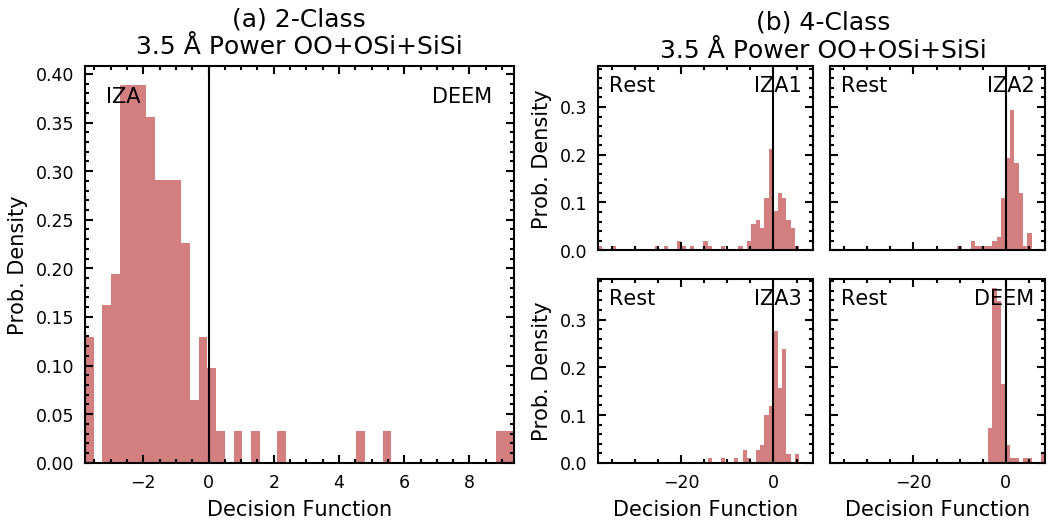

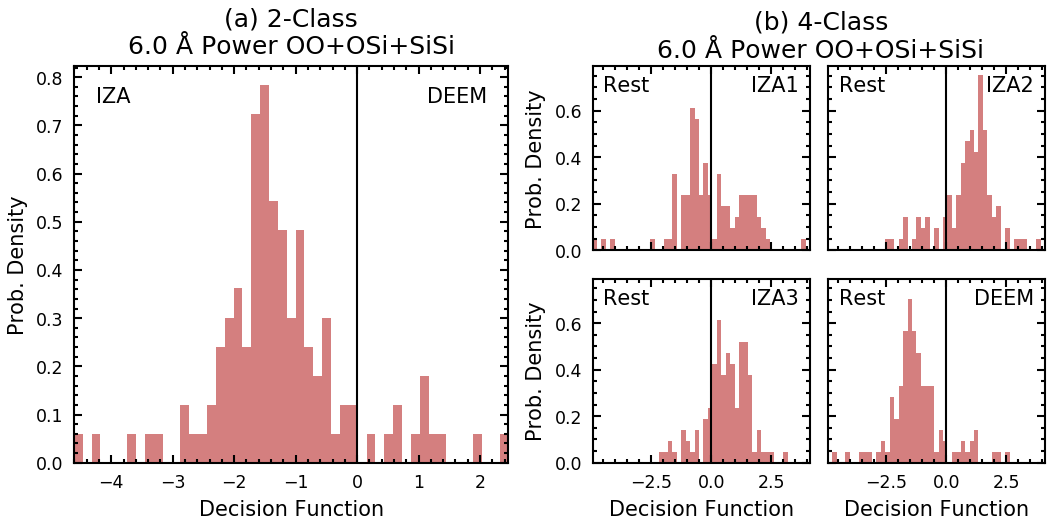

In [29]:
for cutoff in cutoffs:
    
    # Automatic model selection
#     best_spectrum_2 = best_2class_model[cutoff]['best_spectrum']
#     best_species_2 = best_2class_model[cutoff]['best_species']
    
#     best_spectrum_4 = best_4class_model[cutoff]['best_spectrum']
#     best_species_4 = best_4class_model[cutoff]['best_species']
    
    # Manual model selection
    best_spectrum_2 = 'Power'
    best_species_2 = 'OO+OSi+SiSi'
    
    best_spectrum_4 = 'Power'
    best_species_4 = 'OO+OSi+SiSi'
    
    fig = plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1))

    axs_2 = fig.add_subplot(gs[0:2, 0:2])
    axs_4 = [fig.add_subplot(gs[i // 2, 2 + (i % 2)]) for i in range(0, 4)]

    dfs_2 = np.loadtxt(
        f'{iza_dir}/{cutoff}/LSVC/{df_type}/2-Class/{best_spectrum_2}/{best_species_2}/svc_structure_dfs.dat'
    )
    dfs_2 = dfs_2[iza_test_idxs]
    
    dfs_4 = np.loadtxt(
        f'{iza_dir}/{cutoff}/LSVC/{df_type}/4-Class/{best_spectrum_4}/{best_species_4}/svc_structure_dfs.dat'
    )
    dfs_4 = dfs_4[iza_test_idxs]
    
    histogram_range = [np.amin(dfs_4), np.amax(dfs_4)]
    histogram_parameters = dict(bins=50, density=True, log=False, color=color_list[1], alpha=0.5)
    
    hist_x_grouper = axs_4[0].get_shared_x_axes()
    for ax in axs_4[1:]:
        hist_x_grouper.join(ax, axs_4[0])
        
    hist_y_grouper = axs_4[0].get_shared_y_axes()
    for ax in axs_4[1:]:
        hist_y_grouper.join(ax, axs_4[0])

    # 2-Class histogram
    h, bin_edges, _ = axs_2.hist(dfs_2, **histogram_parameters)
    bulk = bin_edges[0:-1][h > 1.0E-4]
    bulk_min = np.amin(bulk)
    bulk_max = np.amax(bulk)
    axs_2.set_xlim((bulk_min, bulk_max))
    
    axs_2.set_xlabel('Decision Function')
    axs_2.set_ylabel('Prob. Density')
    axs_2.axvline(0, color=color_list[0], linestyle='-')

    axs_2.text(
        0.05, 0.95, 
        class_names[2][0], 
        verticalalignment='top', horizontalalignment='left',
        transform=axs_2.transAxes
    )
    axs_2.text(
        0.95, 0.95, 
        class_names[2][1], 
        verticalalignment='top', horizontalalignment='right',
        transform=axs_2.transAxes
    )
    
    axs_2.set_title(f'(a) 2-Class\n{cutoff} ' + u'\u00c5 ' + f'{best_spectrum_2} {best_species_2}')

    # 4-Class histograms
    right_edge, left_edge = histogram_range # initialize as opposite
    for adx, ax in enumerate(axs_4):
        h, bin_edges, _ = ax.hist(dfs_4[:, adx], range=histogram_range, **histogram_parameters)
        bulk = bin_edges[0:-1][h > 1.0E-4]
        left_edge = np.minimum(left_edge, np.amin(bulk))
        right_edge = np.maximum(right_edge, np.amax(bulk))        
        
        if adx > 1:
            ax.set_xlabel('Decision Function')
        else:
            ax.tick_params(
                which='both', axis='x',
                labelbottom=False
            )
        if adx % 2 == 0:
            ax.set_ylabel('Prob. Density')
        else:
            ax.tick_params(
                which='both', axis='y',
                labelleft=False
            )
        ax.axvline(0, color=color_list[0], linestyle='-')

        ax.text(
            0.05, 0.95, 
            'Rest', 
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes
        )
        ax.text(
            0.95, 0.95, 
            class_names[4][adx], 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes
        )
        
    for ax in axs_4:
        ax.set_xlim((left_edge, right_edge))
        
    fig.text(
        1.05, 1.05, 
        f'(b) 4-Class\n{cutoff} ' + u'\u00c5 ' + f'{best_spectrum_4} {best_species_4}',
        horizontalalignment='center', verticalalignment='baseline', fontsize='large',
        transform=axs_4[0].transAxes
    )

    fig.savefig(f'../../Results/{cutoff}/df_iza_histogram_{cutoff}_lsvc.pdf', bbox_inches='tight')
    plt.show()

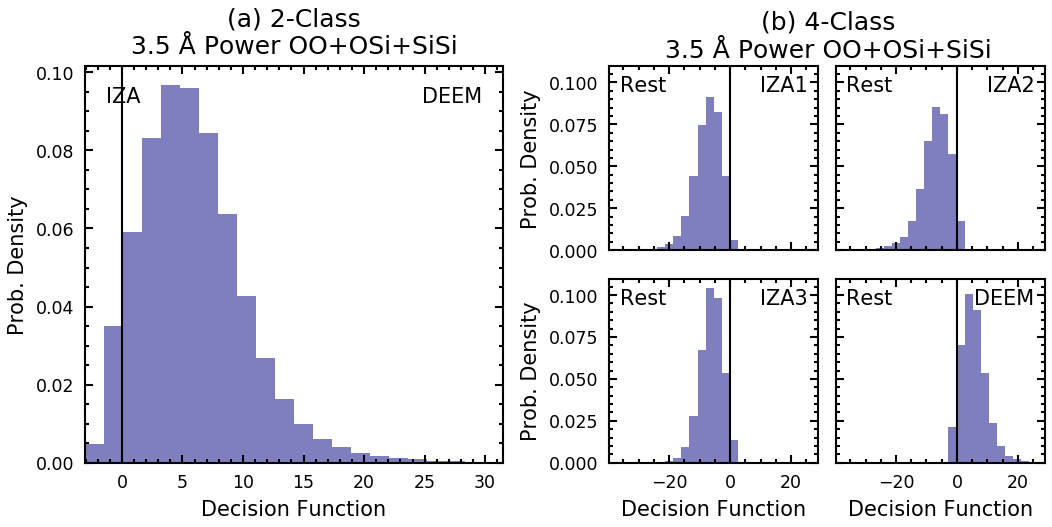

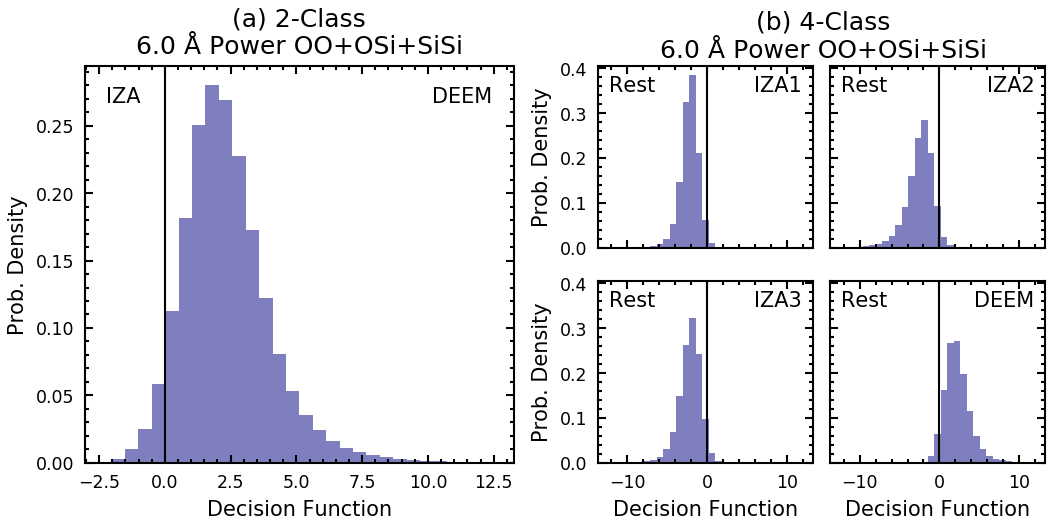

In [30]:
for cutoff in cutoffs:
    
    # Automatic model selection
#     best_spectrum_2 = best_2class_model[cutoff]['best_spectrum']
#     best_species_2 = best_2class_model[cutoff]['best_species']
    
#     best_spectrum_4 = best_4class_model[cutoff]['best_spectrum']
#     best_species_4 = best_4class_model[cutoff]['best_species']
    
    # Manual model selection
    best_spectrum_2 = 'Power'
    best_species_2 = 'OO+OSi+SiSi'
    
    best_spectrum_4 = 'Power'
    best_species_4 = 'OO+OSi+SiSi'
    
    fig = plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
    gs = fig.add_gridspec(nrows=2, ncols=4, width_ratios=(1, 1, 1, 1), height_ratios=(1, 1))

    axs_2 = fig.add_subplot(gs[0:2, 0:2])
    axs_4 = [fig.add_subplot(gs[i // 2, 2 + (i % 2)]) for i in range(0, 4)]

    dfs_2 = np.loadtxt(
        f'{deem_dir}/{cutoff}/LSVC/{df_type}/2-Class/{best_spectrum_2}/{best_species_2}/svc_structure_dfs.dat'
    )
    dfs_2 = dfs_2[deem_test_idxs]
    
    dfs_4 = np.loadtxt(
        f'{deem_dir}/{cutoff}/LSVC/{df_type}/4-Class/{best_spectrum_4}/{best_species_4}/svc_structure_dfs.dat'
    )
    dfs_4 = dfs_4[deem_test_idxs]
    
    histogram_range = [np.amin(dfs_4), np.amax(dfs_4)]
    histogram_parameters = dict(bins=50, density=True, log=False, color=color_list[2], alpha=0.5)

    hist_x_grouper = axs_4[0].get_shared_x_axes()
    for ax in axs_4[1:]:
        hist_x_grouper.join(ax, axs_4[0])
        
    hist_y_grouper = axs_4[0].get_shared_y_axes()
    for ax in axs_4[1:]:
        hist_y_grouper.join(ax, axs_4[0])

    # 2-Class histogram
    h, bin_edges, _ = axs_2.hist(dfs_2, **histogram_parameters)
    bulk = bin_edges[0:-1][h > 1.0E-4]
    bulk_min = np.amin(bulk)
    bulk_max = np.amax(bulk)
    axs_2.set_xlim((bulk_min, bulk_max))
    
    axs_2.set_xlabel('Decision Function')
    axs_2.set_ylabel('Prob. Density')
    axs_2.axvline(0, color=color_list[0], linestyle='-')

    axs_2.text(
        0.05, 0.95, 
        class_names[2][0], 
        verticalalignment='top', horizontalalignment='left',
        transform=axs_2.transAxes
    )
    axs_2.text(
        0.95, 0.95, 
        class_names[2][1], 
        verticalalignment='top', horizontalalignment='right',
        transform=axs_2.transAxes
    )
    
    axs_2.set_title(f'(a) 2-Class\n{cutoff} ' + u'\u00c5 ' + f'{best_spectrum_2} {best_species_2}')

    # 4-Class histograms
    right_edge, left_edge = histogram_range # initialize as opposite
    for adx, ax in enumerate(axs_4):
        h, bin_edges, _ = ax.hist(dfs_4[:, adx], range=histogram_range, **histogram_parameters)
        bulk = bin_edges[0:-1][h > 1.0E-4]
        left_edge = np.minimum(left_edge, np.amin(bulk))
        right_edge = np.maximum(right_edge, np.amax(bulk))
        
        if adx > 1:
            ax.set_xlabel('Decision Function')
        else:
            ax.tick_params(
                which='both', axis='x',
                labelbottom=False
            )
        if adx % 2 == 0:
            ax.set_ylabel('Prob. Density')
        else:
            ax.tick_params(
                which='both', axis='y',
                labelleft=False
            )
        ax.axvline(0, color=color_list[0], linestyle='-')

        ax.text(
            0.05, 0.95, 
            'Rest', 
            verticalalignment='top', horizontalalignment='left',
            transform=ax.transAxes
        )
        ax.text(
            0.95, 0.95, 
            class_names[4][adx], 
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes
        )
    
    for ax in axs_4:
        ax.set_xlim((left_edge, right_edge))
        
    fig.text(
        1.05, 1.05, 
        f'(b) 4-Class\n{cutoff} ' + u'\u00c5 ' + f'{best_spectrum_4} {best_species_4}',
        horizontalalignment='center', verticalalignment='baseline', fontsize='large',
        transform=axs_4[0].transAxes
    )

    fig.savefig(f'../../Results/{cutoff}/df_deem_histogram_{cutoff}_lsvc.pdf', bbox_inches='tight')
    plt.show()

# Cantonwise classifications

In [57]:
spectrum_name = 'Power'
species_pairing = 'OO+OSi+SiSi'
n_cantons = 4

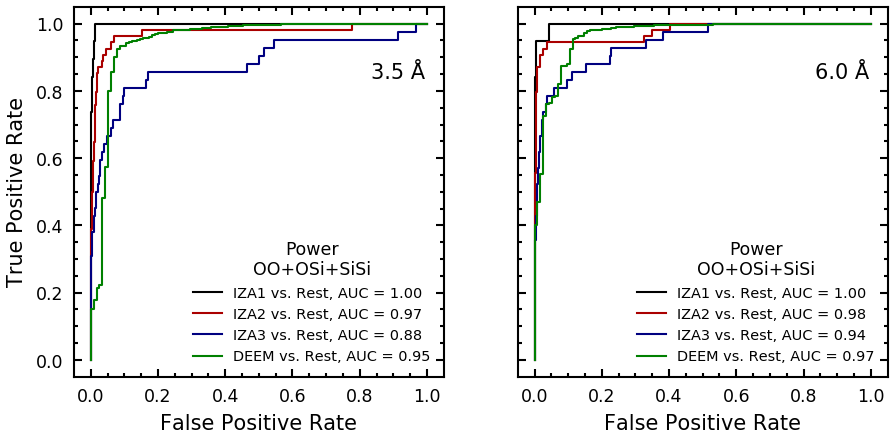

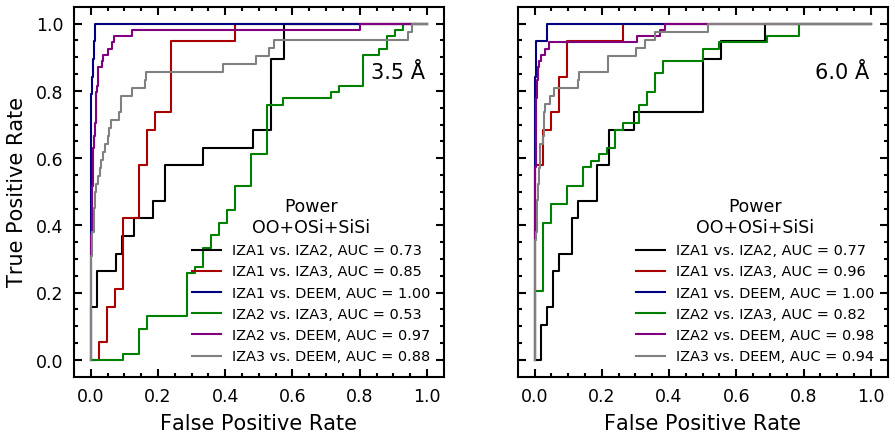

In [88]:
# ROC cantonwise curves
for df_type in df_types:
    fig = plt.figure(figsize=(7.0, 3.5))
    axs = {}
    for cdx, cutoff in enumerate(cutoffs):
        axs[cutoff] = fig.add_subplot(1, 2, cdx+1)
        axs[cutoff].set_aspect('equal')

        data_dir = f'LSVC/{df_type}/4-Class/{spectrum_name}/{species_pairing}'

        dfs_iza = np.loadtxt(f'{iza_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')
        dfs_deem = np.loadtxt(f'{deem_dir}/{cutoff}/{data_dir}/svc_structure_dfs.dat')

        test_dfs = np.concatenate((dfs_iza[iza_test_idxs], dfs_deem[deem_test_idxs]))

        if df_type == 'OvR':
            for i in range(1, n_cantons+1):
                iclass = class_names[4][i-1]
                test_binary_idxs = np.nonzero(test_cantons[4] == i)[0]
                test_binary_cantons = np.ones(len(test_cantons[4]), dtype=int) * -1
                test_binary_cantons[test_binary_idxs] = 1 

                fpr, tpr, thresholds = roc_curve(
                    test_binary_cantons, 
                    test_dfs[:, i-1],
                )
                auc = roc_auc_score(
                    test_binary_cantons, 
                    test_dfs[:, i-1],
                    average='weighted'
                )

                axs[cutoff].plot(fpr, tpr, label=f'{iclass} vs. Rest, AUC = {auc:0.2f}')

        elif df_type == 'OvO':
            df_idx = 0
            for i in range(1, n_cantons+1):
                iclass = class_names[4][i-1]
                for j in range(i+1, n_cantons+1):
                    jclass = class_names[4][j-1]
                    test_binary_idxs = np.nonzero(
                        np.logical_or(test_cantons[4] == i, test_cantons[4] == j)
                    )[0]

                    fpr, tpr, thresholds = roc_curve(
                        test_cantons[4][test_binary_idxs], 
                        test_dfs[test_binary_idxs, df_idx],
                        pos_label=i
                    )
                    auc = roc_auc_score(
                        test_cantons[4][test_binary_idxs],
                        -1*test_dfs[test_binary_idxs, df_idx],
                        average='weighted'
                    )

                    axs[cutoff].plot(fpr, tpr, label=f'{iclass} vs. {jclass}, AUC = {auc:0.2f}')
                    df_idx += 1
                    
        legend = axs[cutoff].legend(
            loc='lower right', 
            bbox_to_anchor=(1.0, 0.0), 
            fontsize='x-small',
            title_fontsize='small',
            title=f'{spectrum_name}\n{species_pairing}'
        )
        legend.get_title().set_multialignment('center')
        
        axs[cutoff].set_xlabel('False Positive Rate')
        axs[cutoff].text(
            0.95, 0.85,
            f'{cutoff} ' + u'\u00c5',
            horizontalalignment='right',
            verticalalignment='top',
            transform=axs[cutoff].transAxes
        )
    
    axs[3.5].set_ylabel('True Positive Rate')
    axs[6.0].tick_params(axis='y', which='both', labelleft=False)

plt.show()